In [1]:
## adapted from https://colab.research.google.com/drive/12zBvL0v0qZHbpSGXLLjHfQ0w6OZOVHaB#scrollTo=KhLt6VA3wvCB
# https://github.com/MilaNLProc/contextualized-topic-models#preprocessing

In [2]:
%%capture
!pip install contextualized-topic-models==1.8.1
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [3]:
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import bert_embeddings_from_file, TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing
from contextualized_topic_models.datasets.dataset import CTMDataset
from contextualized_topic_models.evaluation.measures import CoherenceNPMI, InvertedRBO
from gensim.corpora.dictionary import Dictionary
from gensim.models import ldamodel 
import os
import numpy as np
import pickle
import pandas as pd

### Let's read our data files and store the documents as lists of strings

In [4]:
# MODEL DATA CATALOG ABSTRACT DATA:
df = pd.read_csv('abstracts.csv')
wp = WhiteSpacePreprocessing(df.Text)
text_training_preprocessed, text_training_not_preprocessed, vocab_list = wp.preprocess()
# print(df.Text[12])

In [5]:
# DATA USED IN COLAB EXAMPLE:
# %%capture
# !wget https://raw.githubusercontent.com/vinid/data/master/dbpedia_sample_abstract_20k_unprep.txt
# !wget https://raw.githubusercontent.com/vinid/data/master/dbpedia_sample_abstract_20k_prep.txt
    
# with open("dbpedia_sample_abstract_20k_prep.txt", 'r') as fr_prep:
#   text_training_preprocessed = [line.strip() for line in fr_prep.readlines()]

# with open("dbpedia_sample_abstract_20k_unprep.txt", 'r') as fr_unprep:
#   text_training_not_preprocessed = [line.strip() for line in fr_unprep.readlines()]

### NOTE: Make sure that the lenghts of the two lists of documents are the same and the index of a not preprocessed document corresponds to the index of the same preprocessed document.

In [6]:
print(len(text_training_preprocessed) == len(text_training_not_preprocessed))
print(len(text_training_not_preprocessed))

True
40


## Split into train/test

In [7]:
training_bow_documents = text_training_preprocessed[0:38]
training_contextual_document = text_training_not_preprocessed[0:38]

testing_bow_documents = text_training_preprocessed[38:]
testing_contextual_documents = text_training_not_preprocessed[38:]

## Create the training set

In [8]:
#uncomment to use regular BERT
# tp = TopicModelDataPreparation("bert-base-nli-mean-tokens")

# Using SPECTER from ALLENAI
tp = TopicModelDataPreparation("allenai-specter")

training_dataset = tp.create_training_set(training_contextual_document, training_bow_documents)

# TODO implement sciBERT:
# notes...
# from transformers import AutoTokenizer, AutoModel
# tokenizer = AutoTokenizer.from_pretrained("gsarti/scibert-nli")
# model = AutoModel.from_pretrained("gsarti/scibert-nli")

# see https://www.kaggle.com/karlie777/covid-19-papers for an example

#### Let's check the vocabulary

In [9]:
tp.vocab[:10]

['ability',
 'absence',
 'acceleration',
 'accepted',
 'acceptor',
 'acceptors',
 'access',
 'accommodates',
 'account',
 'accounted']

In [10]:
#TODO check BERT input size
ctm = CombinedTM(input_size=len(tp.vocab), bert_input_size=768, num_epochs=200, n_components=9)
ctm.fit(training_dataset) 

Epoch: [200/200]	 Seen Samples: [7600/7600]	Train Loss: 799.3898540296053	Time: 0:00:00.152418: : 200it [00:31,  6.33it/s]


## Get topics list

In [11]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/opt/anaconda3/envs/USGS_1/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
ctm.get_topics(5)

defaultdict(list,
            {0: ['dependent', 'motion', 'aleatory', 'independent', 'motions'],
             1: ['climate', 'habitats', 'conditions', 'stream', 'occurrence'],
             2: ['environmental', 'size', 'migrate', 'annual', 'animals'],
             3: ['transport', 'redox', 'simulated', 'solute', 'processes'],
             4: ['culverts', 'tip', 'unsteady', 'thornthwaite', 'generality'],
             5: ['point', 'ptcount', 'map', 'number', 'manually'],
             6: ['pumping',
              'conductivity',
              'geometry',
              'lithologic',
              'spreadsheet'],
             7: ['modeling', 'change', 'understanding', 'flooding', 'sea'],
             8: ['user', 'geochemical', 'run', 'waters', 'adapted']})

## Look at a word cloud

In [13]:
%%capture
pip install matplotlib==3.1.3

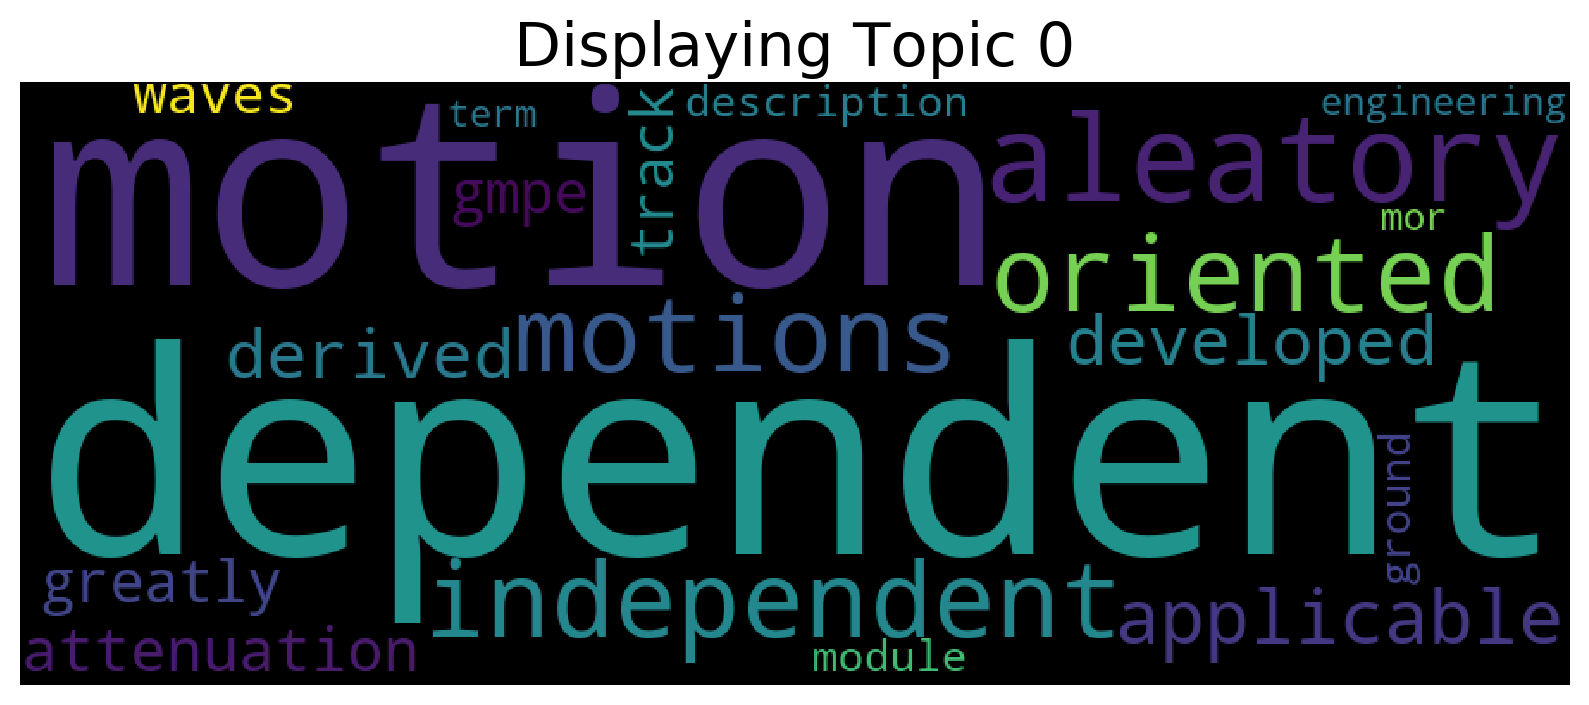

In [14]:
ctm.get_wordcloud(topic_id=0, n_words=20)

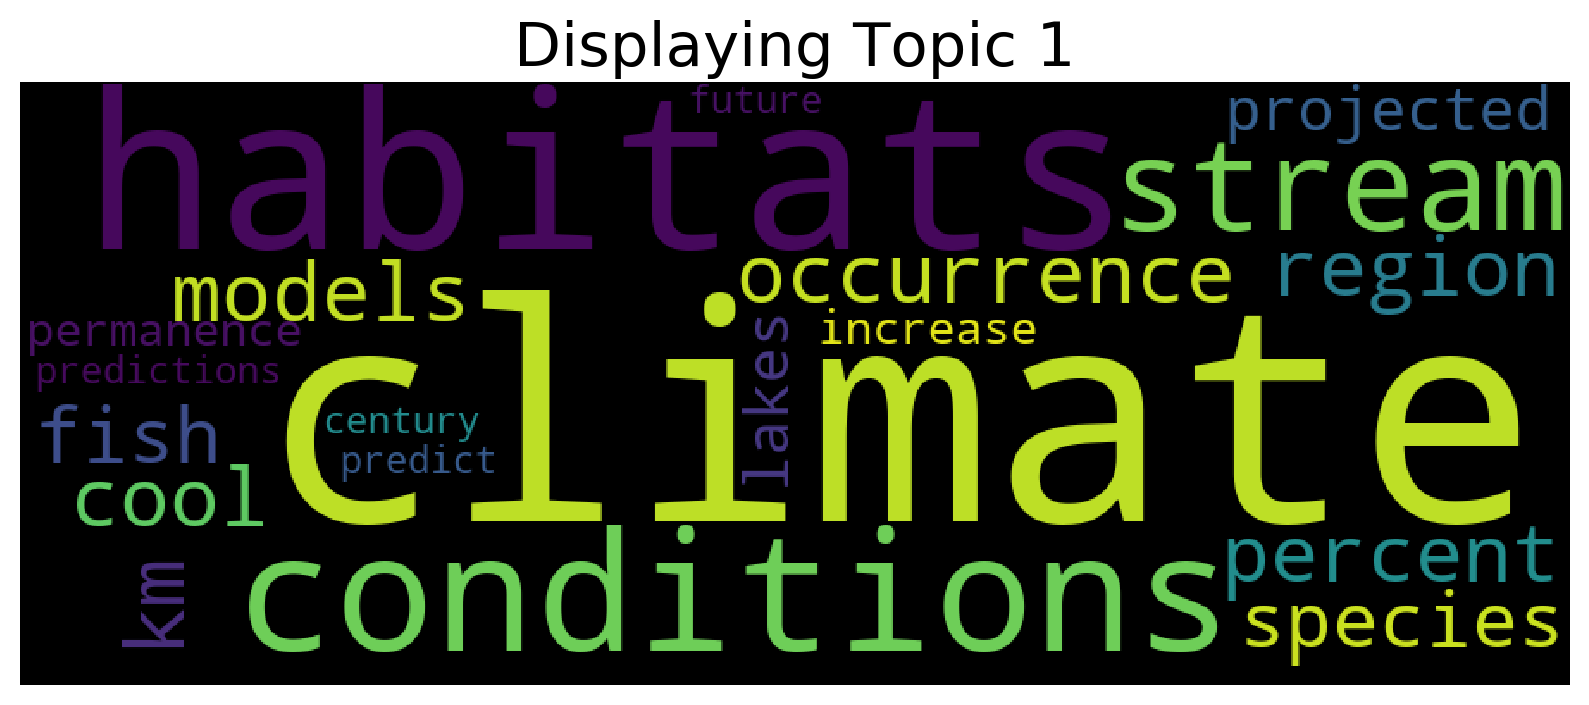

In [15]:
ctm.get_wordcloud(topic_id=1, n_words=20)

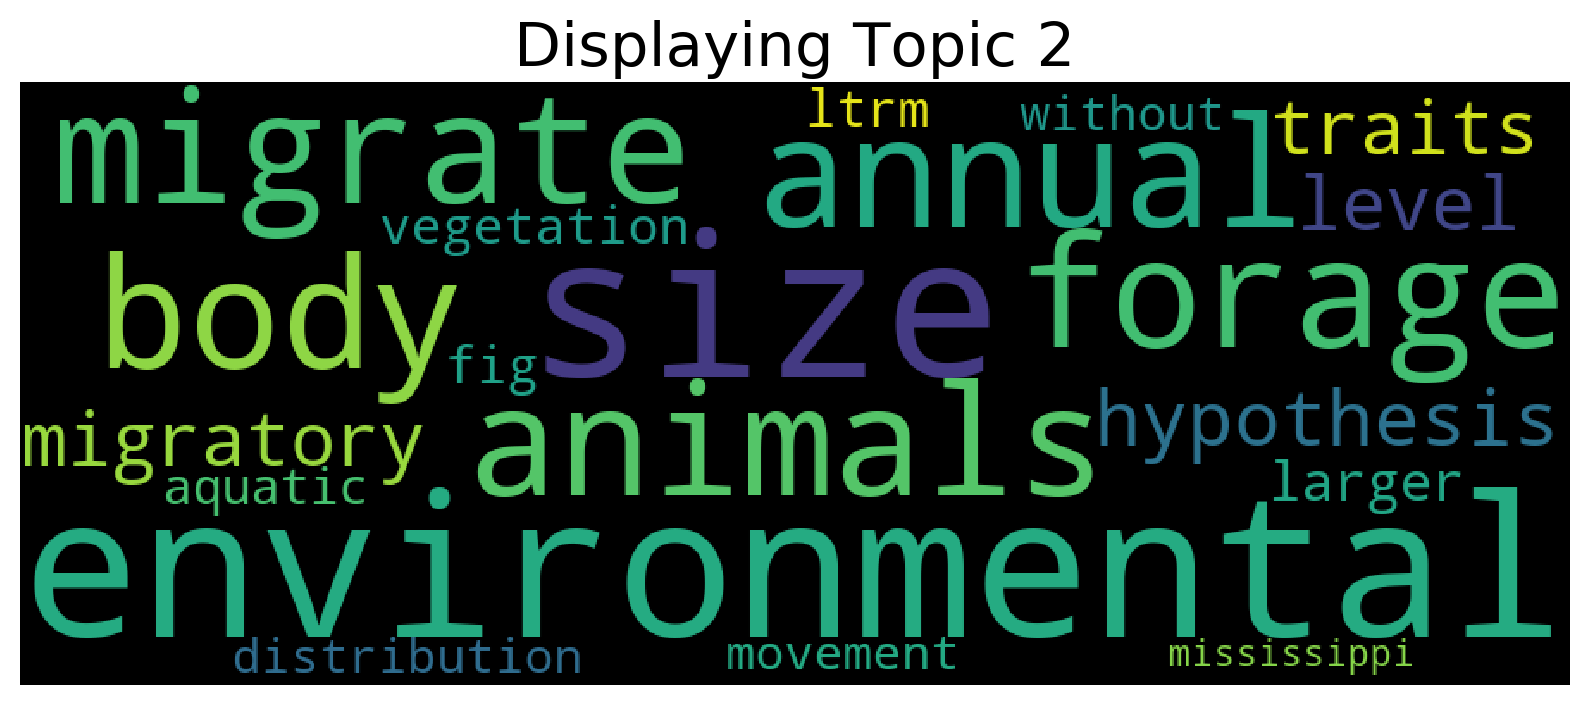

In [16]:
ctm.get_wordcloud(topic_id=2, n_words=20)

## Use the test set

In [17]:
testing_dataset = tp.create_test_set(testing_contextual_documents, testing_bow_documents) # create dataset for the testset
predictions = ctm.get_doc_topic_distribution(testing_dataset, n_samples=1)

0it [00:00, ?it/s]

Sampling: [1/1]: : 1it [00:00,  9.86it/s]


In [69]:
#Select the test_document to view:
selected_doc = 0

print('probability for each topic', predictions[selected_doc])
print()
topic_index = np.argmax(predictions[selected_doc])
print('arg_max:', topic_index)
print()
print('original text:', testing_contextual_documents[selected_doc][0:350])
print()
print('topic_keywords:', ctm.get_topics(5)[topic_index])
# print(ctm.get_word_distribution_by_topic_id(topic_index)[0:20])

probability for each topic [0.00812311 0.02846386 0.23385856 0.11285107 0.0106822  0.14383984
 0.35939056 0.05258514 0.05020569]

arg_max: 6

original text: The computer program, Scoops3D, evaluates slope stability throughout a digital landscape represented by a digital elevation model (DEM). The program uses a three-dimensional (3D) method of columns approach to assess the stability of many (typically millions) potential landslides within a user-defined size range. For each potential landslide (or fai

topic_keywords: ['pumping', 'conductivity', 'geometry', 'lithologic', 'spreadsheet']


In [19]:
# pt = ctm.get_predicted_topics(testing_dataset, n_samples=1)
# print(pt)

## Evaluate the model

## LDA

#### We are going to use gensim's LDA implementation and the preprocessed text to learn topics from Wikipedia

In [22]:
lda_text = list(map(lambda x : x.split(), training_bow_documents))

id2word = Dictionary(lda_text)
texts = lda_text
corpus = [id2word.doc2bow(text) for text in texts]

lda_model = ldamodel.LdaModel(
   corpus=corpus, id2word=id2word, num_topics=9, passes=10, alpha='auto', per_word_topics=True, iterations=200)

In [23]:
lda_topics = []
for i in range(9):
    t = [w[0] for w in lda_model.show_topic(i)[0:10]]
    lda_topics.append(t)

In [24]:
lda_topics[0]

['stream',
 'model',
 'permanence',
 'streamflow',
 'conditions',
 'channel',
 'feq',
 'predictions',
 'structure',
 'flow']

## coherence score

In [ ]:
#LDA topics
npmi = CoherenceNPMI(texts=texts, topics=lda_topics)
npmi.score()

In [ ]:
#Combine topic score
# TODO should this be lda text??  
npmi = CoherenceNPMI(texts=texts, topics=ctm.get_topic_lists(9))
npmi.score()
# Exception: Words in topics are less than topk


## pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models
import gensim
pyLDAvis.enable_notebook()

#TODO might need to run this on colab. Couldn't get it to run in a notebook.

In [ ]:
# from IPython.core.display import HTML

# viz = pyLDAvis.display(LDAvis_prepared)
# HTML(viz)

%matplotlib inline
vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, corpus=corpus, dictionary=id2word)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

# topic_model = ctm, corpus = 

# lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
# pyLDAvis.show(lda_display)